<a href="https://colab.research.google.com/github/jeonghojo00/SpeechRecognition/blob/main/LibriSpeech_DeepSpeech2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Set up

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to the package folder
%cd '/content/drive/MyDrive/Colab Notebooks/SpeechRecognition/train'
# Verify the contents of the current folder
!ls

/content/drive/MyDrive/Colab Notebooks/SpeechRecognition/train
checkpoint  LibriSpeech  __pycache__  tb_logs	      train.py
kenlm	    model.py	 scorer.py    textprocess.py  utils.py


In [ ]:
# First Check if torch, torch-xla, torchaudio, and torchvision are at the compaitible versions
! pip list | grep torch

pytorch-lightning             1.8.4.post0
torch                         1.13.0+cu116
torchaudio                    0.13.0+cu116
torchmetrics                  0.11.0
torchsummary                  1.5.1
torchtext                     0.14.0
torchvision                   0.14.0+cu116


In [ ]:
!pip install pytorch-lightning
!pip install pyctcdecode
!pip install https://github.com/kpu/kenlm/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import sys
import torch
import pickle
import random
import torchaudio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from datetime import timedelta

# Audio Processing
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

# Scoring
from scorer import wer, cer
from textprocess import GreedyDecoder, Decoder, TextTransform
from utils import data_processing, count_parameters

# Models
from model import DeepSpeech2, DeepSpeech2_DSC

# Pytorch libraries for models and data input
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torchvision
from torchvision import models
from torchvision.transforms import transforms, ToTensor
import torchaudio

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

# https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/

In [ ]:
print(sys.version)
!python --version  # checks version from command line
print(torch.__version__)
print(torchvision.__version__)
print(torchaudio.__version__)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]
Python 3.8.16
1.13.0+cu116
0.14.0+cu116
0.13.0+cu116


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(3407)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {} #Colab allows up to 4

#1. Data Preparation

## 1_1. Import Dataset

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./LibriSpeech", url="train-clean-100", download=False)
test_dataset = torchaudio.datasets.LIBRISPEECH("./LibriSpeech", url="test-clean", download=False)

## 1_2. Data Exploratoin

In [ ]:
data_1 = train_dataset[0]
print(f"waveform.    : {data_1[0]}")
print(f"sample_rate  : {data_1[1]}")
print(f"utterance    : {data_1[2][:85]}...")
print(f"speaker_id   : {data_1[3]}")
print(f"chapter_id   : {data_1[4]}")
print(f"utterance_id : {data_1[5]}")
# waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id
print(f"\nData waveform has a shape of {data_1[0].shape}")

waveform.    : tensor([[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]])
sample_rate  : 16000
utterance    : CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE...
speaker_id   : 103
chapter_id   : 1240
utterance_id : 0

Data waveform has a shape of torch.Size([1, 225360])


In [ ]:
print(data_1[0].shape)

torch.Size([1, 225360])


In [ ]:
from IPython.core.display import display

def waveplot(a_data):
    '''
    This function displays a wave form of an audio file
    sr = sample rate
    '''
    y = a_data[0].numpy().squeeze(0)
    sr = a_data[1]
    captions = a_data[2]

    plt.figure(figsize=(10,4))
    librosa.display.waveplot(y, sr = sr)
    plt.show()

def spectogram(a_data):
    '''
    This function displays a spectogram of an audio file
    sr = sample rate
    '''
    y = a_data[0].numpy().squeeze(0)
    sr = a_data[1]
    captions = a_data[2]

    x = librosa.stft(y)
    xdb = librosa.amplitude_to_db(x) # x into decibel
    plt.figure(figsize=(10,4))
    librosa.display.specshow(xdb, sr = sr, x_axis='time', y_axis='hz')
    plt.colorbar()

def playSound(a_data):
    
    speaker_id = str(a_data[3])
    chapter_id = str(a_data[4])
    utterance_id = str(a_data[5])

    train_path = './DB/LibriSpeech/LibriSpeech/train-clean-100'
    file_numbering = '0'*(4-len(utterance_id)) + utterance_id
    file_path = train_path + f'/{speaker_id}/{chapter_id}/{speaker_id}-{chapter_id}-{file_numbering}.flac'
    print(file_path)
    display(Audio(filename = file_path))

def printCaption(a_data):
    a_caption = a_data[2]
    a_caption = a_caption.split()
    board = []
    words = ""
    num_words = 0
    for i in range(len(a_caption)):
        words = words + " " + a_caption[i]
        num_words += 1
        if num_words == 10 or i == len(a_caption)-1:
            print(words)
            words = ""
            num_words = 0

def exploreData(a_data):
    printCaption(a_data)
    waveplot(a_data)
    spectogram(a_data)
    playSound(a_data)


 CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE
 LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO
 A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND
 TRAVERSED BY A BROOK


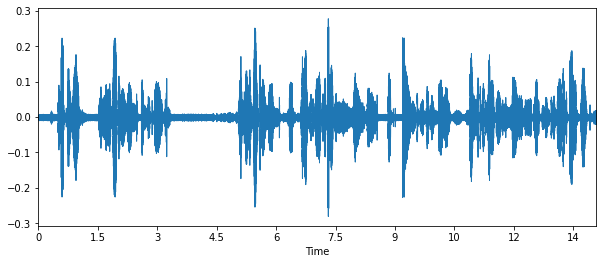

./DB/LibriSpeech/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac


FileNotFoundError: ignored

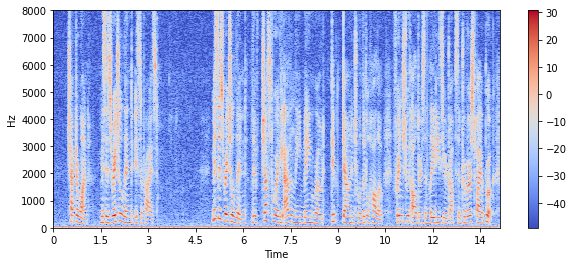

In [ ]:
data_1 = train_dataset[0]
exploreData(data_1)

Steps:

1. Prepare dataset
    1.1 Load dataset
    1.2 Make a dataloader with the dataset
        1.2.1 Convert each data by data_processing function
    1.3 Define a model
        1.3.1 Load a model
        1.3.2 define a optimizer (activation function)
        1.3.3 Define a criterion (loss function)
        1.3.4 Define a scheduler for leraning rate
    1.4 Train
    1.5 Test


# 2. Preprocessing

## 2_1. Text Transformation
Map the character labels for each audio sample into integer labels

In [ ]:
text_transform = TextTransform()

## 2_2. Audio Transformation

Transform the audio into MelSpectrogram and apply Frequency masking and Time masking for data augmentation

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35)
)

valid_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels=128)
)

In [ ]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


In [ ]:
waveform, _, utterance, _, _, _ = data_1
print(f"Waveform has shape of : {waveform.shape}")

Waveform has shape of : torch.Size([1, 225360])


In [ ]:
spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
print(f"Waveform             : {waveform.shape}")
print(f"Transformed waveform : {train_audio_transforms(waveform).shape}")
print(f"Spec                 : {spec.shape}")

Waveform             : torch.Size([1, 225360])
Transformed waveform : torch.Size([1, 128, 1127])
Spec                 : torch.Size([1127, 128])


In [ ]:
label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
print("Labels will be transformed as shown below (characters -> mapped integers")
print(f"Original Utterance has a length of {len(utterance)} while Transformed label has the same length of {len(label)}")
print(label)

Labels will be transformed as shown below (characters -> mapped integers
Original Utterance has a length of 201 while Transformed label has the same length of 201
tensor([ 4.,  9.,  2., 17., 21.,  6., 19.,  1., 16., 15.,  6.,  1., 14., 10.,
        20., 20., 22., 20.,  1., 19.,  2.,  4.,  9.,  6., 13.,  1., 13., 26.,
        15.,  5.,  6.,  1., 10., 20.,  1., 20., 22., 19., 17., 19., 10., 20.,
         6.,  5.,  1., 14., 10., 20., 20., 22., 20.,  1., 19.,  2.,  4.,  9.,
         6., 13.,  1., 13., 26., 15.,  5.,  6.,  1., 13., 10., 23.,  6.,  5.,
         1., 11., 22., 20., 21.,  1., 24.,  9.,  6., 19.,  6.,  1., 21.,  9.,
         6.,  1.,  2., 23., 16., 15., 13.,  6.,  2.,  1., 14.,  2., 10., 15.,
         1., 19., 16.,  2.,  5.,  1.,  5., 10., 17., 17.,  6.,  5.,  1.,  5.,
        16., 24., 15.,  1., 10., 15., 21., 16.,  1.,  2.,  1., 13., 10., 21.,
        21., 13.,  6.,  1.,  9., 16., 13., 13., 16., 24.,  1.,  7., 19., 10.,
        15.,  8.,  6.,  5.,  1., 24., 10., 21.,  9.,  1.,

# 3. Model

- For the speech recogntion model, I implemented Deep Speech 2 model
- Inspired by https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch/
- The overall process will be as below:
    - Spectrogram 
    - N Residual Conv Layer 
    - Linear Layer 
    - N Bidirectional GRU Layer 
    - N Linear Layer 
    - Softmax
    - Argmax to select the most probable one -> Decoding -> ex)"Hello World"
- Implemented Residual Convolutional layer rather than just vanilla Convolutional layer making the model generalize faster and better.
- The paper Visualizing the Loss Landscape of Neural Nets shows that networks with residual connections have a “flatter” loss surface, making it easier for models to navigate the loss landscape and find a lower and more generalizable minima


## 3_1. Configurations

Why CTCLoss? </br>
1. CTC Loss Function aligns audio to transcript. Traditional speech recognition models would require you to align the transcript text to the audio before training, and the model would be trained to predict specific labels at specific frames.

2. The innovation of the CTC loss function is that it allows us to skip this step. Our model will learn to align the transcript itself during training. The key to this is the “blank” label introduced by CTC, which gives the model the ability to say that a certain audio frame did not produce a character. 

Why AdamW and OneCycleLR?
1. Adam is widely used optimizer that helps your model converge more quickly. It has a cons that it does not generalize as well as Stochastic Gradient Descent AKA SGD. AdamW was developed to fix the original Adan's wrong impelementation of Weight Decay. This fix helps with Adam's generalization problem.
2. One Cycle Learning Rate Scheduler can train the neural nets an order of magnitude faster, while keeping their generalizable abilities by staring with low learning rate, warming up to a large maximum learning rate, then decays linearly to the same point of wehre originally started.

In [ ]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val

In [ ]:
class Config(object):
    def __init__(self):
        # Model parameters
        self.n_cnn_layers = 3
        self.n_rnn_layers = 5
        self.rnn_dim= 256
        self.n_class= 29
        self.n_feats = 128
        self.stride = 2 
        self.dropout = 0.3
        self.learning_rate = 1e-5

        # Training parameters
        ## General
        self.train_batch_size = 8
        self.val_batch_size = 4
        self.epochs = 40
        self.device = "gpu"
        self.devices = 1 #8 if device==tpu else 1
        ## Distributed training setup
        self.nodes = 1
        self.gpus = 1
        self.data_workers = 0
        self.val_check_interval= 0.2
        ## Model and Result
        self.ds_loc = './LibriSpeech'
        self.logdir = 'tb_logs'
        self.save_model_path = './SpeechRecognition/checkpoint/LibriSpeech_ImprovedDS2_20221114.pt'
        self.save_model = './SpeechRecognition/checkpoint/LibriSpeech_ImprovedDS2_20221123_model.pt'
        self.load_model = './SpeechRecognition/checkpoint/LibriSpeech_ImprovedDS2_20221113_model.pt'
        self.save_result_path = './SpeechRecognition/checkpoint/LibriSpeech_ImprovedDS2_20221114.pkl'
        self.resume_from_checkpoint = './checkpoint/sr-betas(0.9,0.999)-wd(1e-6)--epoch=09-val_loss=1.98.ckpt'
        self.checkpoint_path = './checkpoint/'
        ## Model for Inference
        self.final_model = './SpeechRecognition/saved_model/sr-wer(0.51)-cer(0.17).pt'

In [ ]:
config = Config()

## 3_2. Model Parameters

In [ ]:
model = DeepSpeech2(
    config.n_cnn_layers,
    config.n_rnn_layers,
    config.rnn_dim,
    config.n_class,
    config.n_feats,
    config.stride,
    config.dropout
    )

print(f'Number of Deep Speech 2 Parameters, {sum([param.nelement() for param in model.parameters()]):,}')

model_DSC = DeepSpeech2_DSC(
    config.n_cnn_layers,
    config.n_rnn_layers,
    config.rnn_dim,
    config.n_class,
    config.n_feats,
    config.stride,
    config.dropout
    )

print(f'Number of Deep Speech2 with Depthwise Separable Convolution Parameters, {sum([param.nelement() for param in model_DSC.parameters()]):,}')

Number of Deep Speech 2 Parameters, 6,244,893
Number of Deep Speech2 with Depthwise Separable Convolution Parameters, 6,197,277


- Each BidirectionalGRU layer has about 120,000 paramers (60,000 for forward and 60,000 for reverse)
- 5 Bidirectional GRU: 5 * 120k = 600k paramters
- It indicates that reducing number of CNN parameters is not very effective because it is just small amount in this networks

#4. Run Experiment (train and test)

## 4_1. With Trainer (Pytorch-Lightning)

In [ ]:
class SpeechModule(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.criterion = nn.CTCLoss(blank=28, zero_infinity=True)
        self.config = config

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=2)

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(params = self.model.parameters(), 
                                           lr = self.config.learning_rate,
                                           betas=(0.9, 0.999),
                                           weight_decay = 1e-6)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.50, patience=6)
        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler, 'monitor': 'val_loss'}

    def step(self, batch):
        spectrograms, labels, input_lengths, label_lengths = batch
        output = self(spectrograms)  # (batch, time, n_class)
        output = output.transpose(0, 1) # (time, batch, n_class)
        loss = self.criterion(output, labels, input_lengths, label_lengths)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.step(batch)
        logs = {'loss': loss, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log("train_loss", loss)
        return {'loss': loss, 'log': logs}

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch)
        self.log("val_loss", loss, prog_bar=True)
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        self.scheduler.step(avg_loss)
        tensorboard_logs = {'val_loss': avg_loss}
        return {'val_loss': avg_loss, 'log': tensorboard_logs}

def checkpoint_callback(config):
    return ModelCheckpoint(
        dirpath=config.checkpoint_path,
        filename = 'sr-lr(1e-5)-dropout(0.5)-betas(0.9,0.999)-wd(1e-5)--{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        verbose=True,
        monitor='val_loss',
        mode='min',
    )

In [ ]:
def main(config):
    train_dataset = torchaudio.datasets.LIBRISPEECH(config.ds_loc, url="train-clean-100", download=True)
    val_dataset = torchaudio.datasets.LIBRISPEECH(config.ds_loc, url="test-clean", download=True)

    train_loader = DataLoader(dataset=train_dataset,
                                batch_size=config.train_batch_size,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'))
    val_loader = DataLoader(dataset=val_dataset,
                                batch_size=config.val_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'val'))
    # Prepare Model
    model = DeepSpeech2(
        n_cnn_layers = config.n_cnn_layers, 
        n_rnn_layers = config.n_rnn_layers,
        rnn_dim = config.rnn_dim,
        n_class = config.n_class,
        n_feats = config.n_feats,
        stride = config.stride,
        dropout = config.dropout)
    print('Number of Model Parameters', sum([param.nelement() for param in model.parameters()]))
    print(f"Using {config.device}")

    speech_module = SpeechModule(model, config)

    logger = TensorBoardLogger(config.logdir, name='speech recognition')

    trainer = Trainer(
        accelerator = config.device, 
        devices = config.devices, 
        logger=logger, 
        max_epochs = config.epochs, 
        gradient_clip_val=1.0,
        callbacks= [checkpoint_callback(config)],
        resume_from_checkpoint=config.resume_from_checkpoint
    )

    trainer.fit(speech_module, train_loader, val_loader)

In [ ]:
if config.checkpoint_path:
    if not os.path.isdir(os.path.dirname(config.checkpoint_path)):
        raise Exception("the directory for path {} does not exist".format(config.checkpoint_path))
config = Config()
main(config)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoint/sr-betas(0.9,0.999)-wd(1e-6)--epoch=09-val_loss=1.98.ckpt


Number of Model Parameters 6244893
Using gpu


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type        | Params
------------------------------------------
0 | model     | DeepSpeech2 | 6.2 M 
1 | criterion | CTCLoss     | 0     
------------------------------------------
6.2 M     Trainable params
0         Non-trainable params
6.2 M     Total params
24.980    Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at ./checkpoint/sr-betas(0.9,0.999)-wd(1e-6)--epoch=09-val_loss=1.98.ckpt


Sanity Checking: 0it [00:00, ?it/s]

Training: 3568it [00:00, ?it/s]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir tb_logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Launching TensorBoard...

KeyboardInterrupt: ignored

In [ ]:
CKPT_PATH = './checkpoint/sr-librispeech-epoch=28-val_loss=0.63.ckpt'
checkpoint = torch.load(CKPT_PATH, map_location="cpu")

model_weights = checkpoint['state_dict']
for key in list(model_weights):
    model_weights[key.replace("model.", "")] = model_weights.pop(key)

In [ ]:
model.load_state_dict(model_weights)

In [ ]:
m = torch.jit.script(model)
SAVE_PATH = './checkpoint/sr-librispeech-epoch=28-val_loss=0.63.pt'
torch.jit.save(m, SAVE_PATH)

In [ ]:
# Load Model
LOAD_PATH = './checkpoint/sr-librispeech-epoch=28-val_loss=0.63.pt'
loaded_model = torch.jit.load(LOAD_PATH, map_location="cpu") # Use cpu to predict the speech
loaded_model.eval()

## 4_2. Traditional Train and Validate

In [ ]:
def train_and_validate(model, device, train_loader, val_loader, criterion, optimizer, scheduler, epochs, iter_meter):
    res = {}
    res['train'] = {}
    res['train']['loss'] = []
    res['train']['cer'] = [] 
    res['train']['wer'] = []   
    res['val'] = {}
    res['val']['loss'] = []
    res['val']['cer'] = [] 
    res['val']['wer'] = []   
    min_wer = 0.7355
    min_loss = 0.952959

    data_len = len(train_loader.dataset)

    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("Training...")
        model.train()
        train_loss = 0
        train_cer, train_wer = [], []

        for batch_idx, _data in enumerate(train_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward
            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            # Evaluate
            loss = criterion(output, labels, input_lengths, label_lengths)
            train_loss += loss.item() / len(train_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                train_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                train_wer.append(wer(decoded_targets[j], decoded_preds[j]))

            # Backward
            loss.backward()

            # Gradient Descent
            optimizer.step()
            scheduler.step()
            iter_meter.step()
            
            if batch_idx % 100 == 0 or batch_idx == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(spectrograms), data_len,
                    100. * batch_idx / len(train_loader), loss.item()))
      
        avg_cer = sum(train_cer) / len(train_cer)
        avg_wer = sum(train_wer) / len(train_wer)
        # Record the result
        res['train']['loss'].append(train_loss)
        res['train']['cer'].append(avg_cer)
        res['train']['wer'].append(avg_wer)
        print('Train set: Loss: {:.4f}, CER: {:4f}, WER: {:.4f}\n'.format(train_loss, avg_cer, avg_wer))         
        
        print("\nValidating...")
        model.eval()
        test_loss = 0
        test_cer, test_wer = [], []
        with torch.no_grad():
            for batch_idx, _data in enumerate(val_loader):
                spectograms, labels, input_lengths, label_lengths = _data
                spectograms, labels = spectograms.to(device), labels.to(device)

                # Forward
                output = model(spectograms) # (batch, time, n_class)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0, 1) #(time, batch, n_class)

                # Evaluate
                loss = criterion(output, labels, input_lengths, label_lengths)
                test_loss += loss.item() / len(val_loader)

                decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
                for j in range(len(decoded_preds)):
                    test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                    test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

        avg_cer = sum(test_cer) / len(test_cer)
        avg_wer = sum(test_wer) / len(test_wer)
        # Record the result
        res['val']['loss'].append(test_loss)
        res['val']['cer'].append(avg_cer)
        res['val']['wer'].append(avg_wer)
        print('Validation set: Loss: {:4f}, CER: {:4f}, WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))     

        if avg_wer <= min_wer and test_loss <= min_loss:
            min_wer = avg_wer
            min_loss = test_loss
            print(f"Model saved with Loss: {test_loss}, CER: {avg_cer}, WER: {avg_wer}")
            m = torch.jit.script(model)
            torch.jit.save(m, config.save_model)    
        
    return res, model


In [ ]:
def main(config):
    # Initialize
    ## Input
    train_url = config.train_url
    test_url = config.test_url
    train_batch_size = config.train_batch_size
    val_batch_size = config.val_batch_size
    ## Model
    n_cnn_layers = config.n_cnn_layers
    n_rnn_layers = config.n_rnn_layers
    rnn_dim = config.rnn_dim
    n_class = config.n_class
    n_feats = config.n_feats
    stride = config.stride
    dropout = config.dropout
    learning_rate = config.learning_rate
    epochs = config.epochs
    ## Results
    model_path = config.save_model_path
    res_path = config.save_result_path

    # Prepare Data
    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Using {device}")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./", url=train_url, download=True)
    val_dataset = torchaudio.datasets.LIBRISPEECH("./", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = DataLoader(dataset=train_dataset,
                                batch_size=train_batch_size,
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    val_loader = DataLoader(dataset=val_dataset,
                                batch_size=val_batch_size,
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'val'),
                                **kwargs)

    iter_meter = IterMeter()

    # Prepare Model
    if config.load_model:
        model = torch.torch.jit.load(config.load_model, map_location=device)
    else:
        model = SpeechRecognitionModel(
            n_cnn_layers = n_cnn_layers, 
            n_rnn_layers = n_rnn_layers,
            rnn_dim = rnn_dim,
            n_class = n_class,
            n_feats = n_feats,
            stride = stride,
            dropout = dropout
            ).to(device)

    print('Number of Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=epochs,
                                            anneal_strategy='linear')

    iter_meter = IterMeter()
    start_time = time.time()

    # Train and Validate the Model
    res, model = train_and_validate(model, device, train_loader, val_loader, criterion, optimizer, scheduler, epochs, iter_meter)
    res['config'] = config
    res['model'] = model_path 
    
    elapsed_time_secs = time.time() - start_time
    msg = "Execution took: %s secs (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))
    print(msg)

    # Save model
    torch.save(model.state_dict(), model_path)

    # Save result in pickle
    with open(res_path, 'wb') as f:
        pickle.dump(res, f)

    # Loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, epochs+1)), res['train']['loss'], label='Train')
    plt.plot(list(range(1, epochs+1)), res['val']['loss'], label='Val')
    plt.legend(loc='upper right')
    plt.title('Loss plot')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # CER plot
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, epochs+1)), res['train']['cer'], label='Train')
    plt.plot(list(range(1, epochs+1)), res['val']['cer'], label='Val')
    plt.legend(loc='upper right')
    plt.title('CER plot')
    plt.xlabel('Epochs')
    plt.ylabel('CER')
    plt.show()

    # WER plot
    plt.figure(figsize=(10, 5))
    plt.plot(list(range(1, epochs+1)), res['train']['wer'], label='Train')
    plt.plot(list(range(1, epochs+1)), res['val']['wer'], label='Val')
    plt.legend(loc='upper right')
    plt.title('WER plot')
    plt.xlabel('Epochs')
    plt.ylabel('WER')
    plt.show()

In [ ]:
results = dict()
results['train'] = dict()
results['eval'] = dict()

results['train']['loss'] = [3.0448, 2.4138, 1.6297, 1.3760, 1.2457, 1.2067, 1.1235, 1.0585,]
results['train']['cer'] = [1.011614, 0.767279, 0.484776, 0.417073, 0.381309, 0.369433, 0.345717, 0.326938]
results['train']['wer'] = [1.0012, 1.0162, 0.9459, 0.8913, 0.8541, 0.8405, 0.8119, 0.7870]

results['eval']['loss'] = [2.9033723474458855, 2.9033723474458855, 1.3671268666973542, 1.1770711373736846, 1.123748, 1.055976, 0.985432, 0.952959]
results['eval']['cer'] = [1.000000, 0.498309, 0.400403, 0.353901, 0.333095, 0.314948, 0.297476, 0.283795]
results['eval']['wer'] = [1.0000, 1.0173, 0.9531, 0.847965534885034, 0.8166, 0.7889, 0.7537, 0.7355]

In [ ]:
main(config)

Using cuda
Number of Model Parameters 6197277

Epoch 1/5
Training...
Train Epoch: 1 [0/28539 (0%)]	Loss: 1.029122
Train Epoch: 1 [3200/28539 (11%)]	Loss: 1.013583
Train Epoch: 1 [6400/28539 (22%)]	Loss: 1.053183
Train Epoch: 1 [9600/28539 (34%)]	Loss: 0.948608
Train Epoch: 1 [12800/28539 (45%)]	Loss: 0.974694
Train Epoch: 1 [16000/28539 (56%)]	Loss: 0.995769
Train Epoch: 1 [19200/28539 (67%)]	Loss: 1.037057
Train Epoch: 1 [22400/28539 (78%)]	Loss: 0.958337


The recent technique for speech recognition
1. WER 1.4: Conformer + Wav2vec 2.0 + SpecAugment-based Noisy Student Training with Libri-Light
2. WER 1.4: w2v-BERT XXL
3. WER 1.5: Conv + Transformer + wav2vec2.0 + pseudo labeling
4. WER 1.7: ContextNet + SpecAugment-based Noisy Student Training with Libri-Light

## 4_3. Evaluate with WER and CER

In [ ]:
from tqdm import tqdm

def evaluate(model, device, val_loader):
    res = {}
    print("Evaluating...")
    model.eval()
    test_cer, test_wer = [], []
    i = 1
    with torch.no_grad():
        for batch_idx, _data in enumerate(tqdm(val_loader)):
            spectograms, labels, input_lengths, label_lengths = _data
            spectograms, labels = spectograms.to(device), labels.to(device)

            # Forward
            output = model(spectograms) # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            decoded_preds, decoded_targets = GreedyDecoder(output, labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))
            if i == 1:
                print(f"Decoded: {decoded_preds}")
                print(f"Actual : {decoded_targets}")
                i+=1

    avg_cer = sum(test_cer) / len(test_cer)
    avg_wer = sum(test_wer) / len(test_wer)
    # Record the result
    res['cer'] = avg_cer
    res['wer'] = avg_wer
    print('Validation set: CER: {:4f}, WER: {:.4f}\n'.format(avg_cer, avg_wer))     

    return res

In [ ]:
eval_dataset = torchaudio.datasets.LIBRISPEECH("./", url=config.test_url, download=True)
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
eval_loader = DataLoader(dataset=eval_dataset,
                        batch_size=1,
                        shuffle=False,
                        collate_fn=lambda x: data_processing(x, 'val'),
                        **kwargs)

# Load Model
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
model_location = './saved_model/sr_improvedDS2_sr=16000_val_loss=0.63_model.pt'
model = torch.jit.load(model_location, map_location=device) # Use cpu to predict the speech

blank_label = 28
collapse_repeated=True

In [ ]:
evaluation = evaluate(model, device, eval_loader)

Evaluating...


  0%|          | 1/2620 [00:00<18:54,  2.31it/s]

Decoded: ['he hoped there would be sto her dinner turnips and carits and brosed betatos and fat buten peces to be latled out inthe thick peppered flower fattend sos']
Actual : ['he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce']


100%|██████████| 2620/2620 [06:44<00:00,  6.47it/s]

Validation set: CER: 0.173090, WER: 0.5089



In [ ]:
m = torch.jit.script(model)
model_filename = 'sr-wer(' + str(round(evaluation['wer'], 2)) + ')-cer(' + str(round(evaluation['cer'], 2)) + ').pt'
model_path = os.path.join('./saved_model', model_filename)
print(model_path)
torch.jit.save(m, model_path)    

./saved_model/sr-wer(0.51)-cer(0.17).pt


#5. Generate an text from an audio file using trained model


In [ ]:
!ls

checkpoint  LibriSpeech  __pycache__  tb_logs	      train.py
kenlm	    model.py	 scorer.py    textprocess.py  utils.py


In [ ]:
# Prepare an audio file
data_1 = test_dataset[0]

speaker_id = str(data_1[3])
chapter_id = str(data_1[4])
utterance_id = str(data_1[5])

test_path = './LibriSpeech/LibriSpeech/test-clean'
file_numbering = '0'*(4-len(utterance_id)) + utterance_id
file_path = test_path + f'/{speaker_id}/{chapter_id}/{speaker_id}-{chapter_id}-{file_numbering}.flac'
# File Path is the the file address
# file_path = "hello.wav"
print(file_path)
display(Audio(filename = file_path))
print(data_1[2])

valid_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels=128)
)

# Preprocess the audio file
waveform, sample_rate = torchaudio.load(file_path)
print(f"waveform shape: {waveform.shape}")
print(f"sample_rate: {sample_rate}")
spec = valid_audio_transforms(waveform).unsqueeze(0)
print(spec.shape)

./LibriSpeech/LibriSpeech/test-clean/1089/134686/1089-134686-0000.flac


HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE
waveform shape: torch.Size([1, 166960])
sample_rate: 16000
torch.Size([1, 1, 128, 835])


In [ ]:
%cd ..

/content/drive/MyDrive/Colab Notebooks/SpeechRecognition


In [ ]:
from pyctcdecode import build_ctcdecoder
import kenlm

labels = [
    "'",  # 0
    " ",  # 1
    "a",  # 2
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "s",
    "t",
    "u",
    "v",
    "w",
    "x",
    "y",
    "z",  # 27
    "_",  # 28, blank
]
# language models from https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tlt-jarvis/models/speechtotext_english_lm
ctcdecoder = build_ctcdecoder(labels=labels,
                              kenlm_model_path = './lm/mixed-lower.binary')

In [ ]:
import re
model_path = './final_model/sr-wer(0.51)-cer(0.17).pt'
use_cuda = torch.cuda.is_available()
torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")
spec = spec.to(device)
# Load Model
model = torch.jit.load(model_path, map_location=device) # Use cpu to predict the speech
model.eval()

blank_label = 28
collapse_repeated=True

with torch.no_grad():
    decode = []
    output = model(spec) # (batch_size, )
    pred_text = Decoder(output, blank_label=28, collapse_repeated=True)

pred_text = re.sub('\s{2,}', ' ', pred_text)
reference_text = data_1[2].lower()
print(f"Original  Text: {reference_text}")
print(f"Predicted Text: {pred_text}")

output2decode = output.squeeze(0).cpu().detach().numpy()
ctc_decoded = ctcdecoder.decode(output2decode)
print(f"CTC decoded   : {ctc_decoded}")

Original  Text: he hoped there would be stew for dinner turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce
Predicted Text: he hoped there would be sto her dinner turnips and carits and brosed betatos and fat buten peces to be latled out inthe thick peppered flower fattend sos
CTC decoded   : he hoped there would be sto her dinner turnips and carats and brosed betatos and fat buton pieces to be ladled out in the thick peppered flower fattens sous


In [ ]:
print(wer(reference_text, pred_text))
print(wer(reference_text, ctc_decoded))

0.42857142857142855
0.35714285714285715
